<a href="https://colab.research.google.com/github/imrealhelper/Linear-Algebra/blob/main/Soft_landing_LCXV_EARTH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy scipy matplotlib cvxpy ecos

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 7.5 MB/s eta 0:00:00


In [96]:
import numpy as np
import scipy.linalg
import scipy.integrate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cvxpy as cp
import time
import math
import pandas as pd # Golden search 결과용

# --- 상수 및 유틸리티 ---
GRAVITY_EARTH = 9.807
EPS = np.finfo(float).eps # 작은 상수

def skew(v):
    """3x1 벡터를 3x3 왜대칭 행렬로 변환"""
    return np.array([[0, -v[2], v[1]],
                     [v[2], 0, -v[0]],
                     [-v[1], v[0], 0]])

# --- 데이터 구조 ---
class RocketParams:
    # (이전과 동일)
    def __init__(self, g, omega, m_dry, m_wet, Isp, phi, rho_min, rho_max,
                 gamma_gs, gamma_p, v_max, r0, v0):
        self.g_vec = np.array(g)
        self.omega_vec = np.array(omega)
        self.m_dry = m_dry
        self.m_wet = m_wet
        self.Isp = Isp
        self.phi = phi
        self.alpha = 1.0 / (Isp * GRAVITY_EARTH * np.cos(phi))
        self.rho_min = rho_min
        self.rho_max = rho_max
        self.gamma_gs_rad = np.deg2rad(gamma_gs)
        self.gamma_p_rad = np.deg2rad(gamma_p)
        self.v_max = v_max
        self.r0 = np.array(r0)
        self.v0 = np.array(v0)
        self.z0_log = np.log(m_wet)
        self.zf_log_min = np.log(m_dry)

        self.nx = 7
        self.nu = 4
        omega_x = skew(self.omega_vec)
        self.Ac = np.zeros((self.nx, self.nx))
        self.Ac[0:3, 3:6] = np.eye(3)
        self.Ac[3:6, 0:3] = -omega_x @ omega_x
        self.Ac[3:6, 3:6] = -2 * omega_x

        self.Bc = np.zeros((self.nx, self.nu))
        self.Bc[3:6, 0:3] = np.eye(3)
        self.Bc[6, 3] = -self.alpha

        self.pc = np.zeros(self.nx)
        self.pc[3:6] = self.g_vec

        cgs = np.cos(self.gamma_gs_rad)
        sgs = np.sin(self.gamma_gs_rad)
        self.H_gs = np.array([[ cgs,  0, -sgs],
                             [-cgs,  0, -sgs],
                             [  0,  cgs, -sgs],
                             [  0, -cgs, -sgs]])
        self.h_gs = np.zeros(4)

        self.e_z_pointing = np.array([0, 0, 1])
        self.cos_gamma_p = np.cos(self.gamma_p_rad)

class Solution:
    # (이전과 동일)
    def __init__(self, status, t, r, v, z, u, xi, cost, T, T_nrm, m, gamma_point):
        self.status = status
        self.t = t
        self.r = r
        self.v = v
        self.z = z
        self.u = u
        self.xi = xi
        self.cost = cost
        self.T = T
        self.T_nrm = T_nrm
        self.m = m
        self.gamma_point = gamma_point

def failed_solution(N_fail=0):
    # (이전과 동일)
    return Solution("FAILED", np.zeros(N_fail), np.zeros((3,N_fail)), np.zeros((3,N_fail)),
                    np.zeros(N_fail), np.zeros((3,N_fail-1)), np.zeros(N_fail-1),
                    float('inf'), np.zeros((3,N_fail-1)), np.zeros(N_fail-1),
                    np.zeros(N_fail), np.zeros(N_fail-1))

# --- ZOH 이산화 ---
def discretize_zoh(Ac, Bc, pc, dt):
    # (이전과 동일)
    nx, nu = Ac.shape[0], Bc.shape[1]
    M = np.zeros((nx + nu + 1, nx + nu + 1))
    M[:nx, :nx] = Ac
    M[:nx, nx:nx+nu] = Bc
    M[:nx, nx+nu] = pc
    try:
        M_exp = scipy.linalg.expm(M * dt)
    except Exception as e:
        print(f"Error in expm: {e}")
        return None, None, None
    A = M_exp[:nx, :nx]
    B = M_exp[:nx, nx:nx+nu]
    p_discrete = M_exp[:nx, nx+nu]
    return A, B, p_discrete

# --- 고정된 최종 시간 LCvx 문제 풀이 (차원 및 인덱싱 수정됨) ---
def solve_pdg_fft(rocket: RocketParams, t_f: float, N: int = 76):
    """고정된 시간 t_f에 대해 LCvx 로켓 착륙 문제를 풉니다."""

    if t_f <= 1e-6: return failed_solution(N)

    dt = t_f / (N - 1)
    t_nodes = np.linspace(0, t_f, N)
    A_d, B_d, p_d = discretize_zoh(rocket.Ac, rocket.Bc, rocket.pc, dt)

    if A_d is None: return failed_solution(N)

    # --- CVXPY 최적화 문제 설정 ---
    r_var = cp.Variable((3, N), name='r')
    v_var = cp.Variable((3, N), name='v')
    z_var = cp.Variable((1, N), name='z')         # shape (1, N)
    u_accel_var = cp.Variable((3, N - 1), name='u_accel')
    xi_var = cp.Variable((1, N - 1), name='xi')   # shape (1, N-1)

    # 상태 벡터 묶음
    x_var = cp.vstack([r_var, v_var, z_var])      # shape (7, N)

    # --- 목적 함수 ---
    # xi_var는 (1, N-1)이므로 sum은 스칼라
    objective = cp.Minimize(dt * cp.sum(xi_var))

    # --- 제약 조건 ---
    constraints = []

    # 1. 동역학 제약
    for k in range(N - 1):
        # k번째 제어 벡터 (shape (4,1)) 구성 시 인덱싱 주의
        try:
          u_ctrl_k = cp.hstack([u_accel_var[:, k], xi_var[:, k]])
        except:
          raise ValueError("u_ctrol_k")
        constraints += [x_var[:, k+1] == A_d @ x_var[:, k] + B_d @ u_ctrl_k + p_d]

    # 2. 추력 경계 (근사, LCvx 핵심)
    for k in range(N - 1):
        t_k = t_nodes[k]
        # 로그 안의 값이 음수가 되지 않도록 max 사용
        z0_val = np.log(max(EPS, rocket.m_wet - rocket.alpha * rocket.rho_max * t_k))
        mu_min_val = rocket.rho_min * np.exp(-z0_val)
        mu_max_val = rocket.rho_max * np.exp(-z0_val)
        # z_var[0, k] 및 xi_var[0, k] 사용 (스칼라)
        delta_z_k = z_var[0, k] - z0_val

        constraints += [xi_var[0, k] >= mu_min_val * (1 - delta_z_k + 0.5 * cp.square(delta_z_k))]
        constraints += [xi_var[0, k] <= mu_max_val * (1 - delta_z_k)]

    # 3. 질량 물리 경계
    for k in range(N):
        t_k = t_nodes[k]
        z0_val = np.log(max(EPS, rocket.m_wet - rocket.alpha * rocket.rho_max * t_k))
        z_upper_val = np.log(max(EPS, rocket.m_wet - rocket.alpha * rocket.rho_min * t_k))
        # z_var[0, k] 사용 (스칼라)
        constraints += [z_var[0, k] >= z0_val]
        constraints += [z_var[0, k] <= z_upper_val]

    # 4. 추력 경계 (LCvx 슬랙)
    # cp.norm(u_accel_var, 2, axis=0) 결과는 (N-1,)
    # xi_var는 (1, N-1). CVXPY가 브로드캐스팅 가능해야 함.
    constraints += [cp.norm(u_accel_var, 2, axis=0) <= xi_var[0, :]] # 명시적으로 슬라이싱

    # 5. 자세 포인팅 제약
    # rocket.e_z_pointing @ u_accel_var 결과는 (N-1,)
    constraints += [rocket.e_z_pointing @ u_accel_var >= xi_var[0, :] * rocket.cos_gamma_p] # 명시적으로 슬라이싱

    # 6. 글라이드 슬로프 제약
    constraints += [rocket.H_gs @ r_var <= rocket.h_gs[:, np.newaxis]]

    # 7. 속도 상한
    constraints += [cp.norm(v_var, 2, axis=0) <= rocket.v_max]

    # 8. 경계 조건
    constraints += [r_var[:, 0] == rocket.r0]
    constraints += [v_var[:, 0] == rocket.v0]
    constraints += [z_var[0, 0] == rocket.z0_log] # 스칼라 인덱싱
    constraints += [r_var[:, N-1] == 0]
    constraints += [v_var[:, N-1] == 0]
    constraints += [z_var[0, N-1] >= rocket.zf_log_min] # 스칼라 인덱싱

    # --- 문제 풀이 ---
    problem = cp.Problem(objective, constraints)
    try:
        problem.solve(solver=cp.ECOS, verbose=False, abstol=1e-3, reltol=1e-3, feastol=1e-3, max_iters=100000)
    except cp.SolverError as e:
        print(f"Solver failed for tf={t_f:.2f}: {e}")
        return failed_solution(N)

    # --- 결과 저장 및 후처리 (차원 주의) ---
    if problem.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
        status = problem.status
        cost = problem.value
        r_opt = r_var.value
        v_opt = v_var.value
        try:
          z_opt = z_var.value[0, :]        # (N,) 형태로 추출
        except:
          raise ValueError("z_opt")
        u_accel_opt = u_accel_var.value  # (3, N-1)
        try:
          xi_opt = xi_var.value[0, :]      # (N-1,) 형태로 추출
        except:
          raise ValueError("xi_var")

        m_opt = np.exp(z_opt)            # (N,)
        m_ctrl = m_opt[:-1]              # (N-1,)

        T_opt = u_accel_opt * m_ctrl     # (3, N-1) * (N-1,) -> (3, N-1) 브로드캐스팅
        T_nrm_opt = np.linalg.norm(T_opt, axis=0) # (N-1,)

        # 0으로 나누기 방지하며 포인팅 각도 계산
        safe_T_nrm = np.maximum(T_nrm_opt, EPS) # 0 대신 작은 양수 사용
        cos_vals = np.clip( (rocket.e_z_pointing @ T_opt) / safe_T_nrm, -1.0, 1.0)
        gamma_point_opt = np.rad2deg(np.arccos(cos_vals)) # (N-1,)

        return Solution(status, t_nodes, r_opt, v_opt, z_opt, u_accel_opt, xi_opt,
                        cost, T_opt, T_nrm_opt, m_opt, gamma_point_opt)
    else:
        print(f"Optimization status for tf={t_f:.2f}: {problem.status}")
        return failed_solution(N)

# --- 황금 분할 탐색 ---
def golden_search(func, a, b, tol=1e-3, max_iter=100):
    # (이전과 동일)
    inv_phi = (np.sqrt(5) - 1) / 2
    inv_phi2 = (3 - np.sqrt(5)) / 2

    h = b - a
    if h <= tol:
        mid_point = (a + b) / 2
        return mid_point, func(mid_point)

    n = int(np.ceil(np.log(tol / h) / np.log(inv_phi)))
    n = min(n, max_iter)

    c = a + inv_phi2 * h
    d = a + inv_phi * h
    yc_sol = func(c) # func는 Solution 객체 반환
    yd_sol = func(d)
    yc = yc_sol.cost
    yd = yd_sol.cost


    print(f"Golden Search Starts: [{a:.2f}, {b:.2f}], Max iter: {n}")
    for k in range(n):
        print(f" iter {k+1}: a={a:.3f} b={b:.3f} c={c:.3f}({yc:.3e}) d={d:.3f}({yd:.3e}) h={h:.3f}")
        if yc < yd:
            b = d
            d = c
            yd = yc
            yd_sol = yc_sol # Solution 객체도 업데이트
            h = b - a
            c = a + inv_phi2 * h
            if k < n - 1:
                yc_sol = func(c)
                yc = yc_sol.cost
        else:
            a = c
            c = d
            yc = yd
            yc_sol = yd_sol # Solution 객체도 업데이트
            h = b - a
            d = a + inv_phi * h
            if k < n - 1:
                yd_sol = func(d)
                yd = yd_sol.cost

        if h <= tol: break

    # 최종 결과: 비용이 더 낮은 지점의 시간과 Solution 객체 반환
    if yc < yd:
         print(f"Golden Search Result: tf={c:.3f}, cost={yc:.3e}")
         return c, yc_sol
    else:
         print(f"Golden Search Result: tf={d:.3f}, cost={yd:.3e}")
         return d, yd_sol


# --- 재사용 발사체 파라미터 (Table 2 및 Case 1 기준) ---
# 지구 중력 사용, NED -> ENU 변환 (예시)
g_vec = [0, 0, -GRAVITY_EARTH]
# 필요시 지구 자전 반영 (여기서는 생략하거나 0으로 처리)
omega_vec = [0, 0, 0]

# 질량
m_dry = 15533.0    # kg
m_wet = 22533.0    # kg

# 엔진 성능
Isp = 304.06       # s
phi = 0.0          # 엔진 칸트 각 (TVC로 제어하므로 0으로 가정)
rho_min = 298e3    # N
rho_max = 745e3    # N

# 기타 제약 및 동역학 파라미터
gamma_gs = 45   # glide slope 제한 (deg)
gamma_p =  15   # pointing angle 제한 (deg)
v_max = 500.0      # 최대 속도 (m/s), 필요에 따라 조정

# 초기 조건 (Case 1, NED에서 ENU로 변환)
# NED: r0_NED = [-0.6, 0, -5] km, v0_NED = [44, 0, 272.5] m/s
# ENU: r0 = [east, north, up] -> r0 = [0, -600, 5000] m
# v0 = [east, north, up] -> v0 = [0, 44, -272.5] m/s (내려가는 속도이므로 z는 음수)
r0 = [0.0, -600.0, 6000.0]  # m
v0 = [1.0, 42, -234]    # m/s

rocket_params = RocketParams(g_vec, omega_vec, m_dry, m_wet, Isp, phi,
                             rho_min, rho_max, gamma_gs, gamma_p, v_max,
                             r0, v0)

print("\n--- Finding Optimal Time using Golden Search ---")
# tf 범위 추정 (안전하게 넓게 잡기)
tf_low_bound = 10.0
tf_high_bound = 100.0 # 예시 값, 문제에 따라 조정 필요

# Golden search 실행
N_nodes_search = 76 # Golden search 내부에서 사용할 노드 수
tf_opt, pdg_solution = golden_search(
    lambda t: solve_pdg_fft(rocket_params, t, N=N_nodes_search),
    tf_low_bound,
    tf_high_bound,
    tol=0.1 # 시간 허용 오차 (초)
)


# 최종 결과 출력 및 시각화
if pdg_solution.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
    print("\n--- Final Optimization Result ---")
    print(f"Status: {pdg_solution.status}")
    print(f"Optimal Final Time (tf): {tf_opt:.3f} s")
    print(f"Optimal Cost (sum xi*dt): {pdg_solution.cost:.4f}")

    # 여기에 시각화 코드 추가
    # 예: plot_3d_trajectory_with_projection(pdg_solution.r, pdg_solution.T, N_nodes_search-1, title_suffix=f"(LCvx, tf={tf_opt:.2f})")
    # 다른 플롯들도 유사하게 구현

else:
    print("\n--- Optimization Failed to Find Optimal Time ---")


--- Finding Optimal Time using Golden Search ---
Optimization status for tf=65.62: infeasible
Golden Search Starts: [10.00, 100.00], Max iter: 15
 iter 1: a=10.000 b=100.000 c=44.377(6.712e+02) d=65.623(inf) h=90.000
Optimization status for tf=31.25: infeasible
 iter 2: a=10.000 b=65.623 c=31.246(inf) d=44.377(6.712e+02) h=55.623
Optimization status for tf=52.49: infeasible
 iter 3: a=31.246 b=65.623 c=44.377(6.712e+02) d=52.492(inf) h=34.377
 iter 4: a=31.246 b=52.492 c=39.361(6.245e+02) d=44.377(6.712e+02) h=21.246
Optimization status for tf=36.26: infeasible
 iter 5: a=31.246 b=44.377 c=36.262(inf) d=39.361(6.245e+02) h=13.131
 iter 6: a=36.262 b=44.377 c=39.361(6.245e+02) d=41.277(6.408e+02) h=8.115
 iter 7: a=36.262 b=41.277 c=38.177(6.167e+02) d=39.361(6.245e+02) h=5.016
 iter 8: a=36.262 b=39.361 c=37.446(6.149e+02) d=38.177(6.167e+02) h=3.100
 iter 9: a=36.262 b=38.177 c=36.993(6.132e+02) d=37.446(6.149e+02) h=1.916
Optimization status for tf=36.71: infeasible
 iter 10: a=36.2

In [68]:
!pip install latex

In [69]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


--- Plotting Results ---


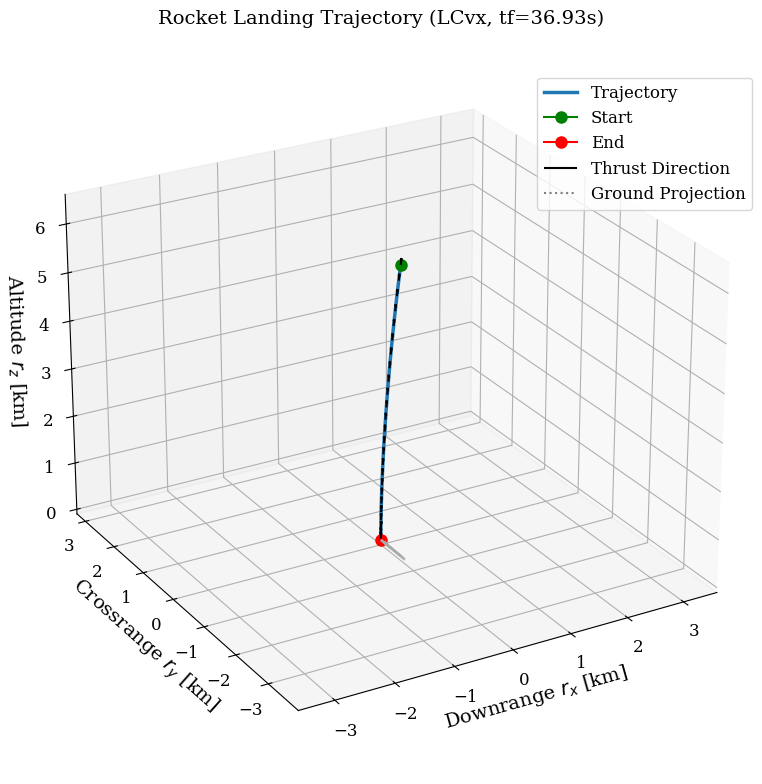

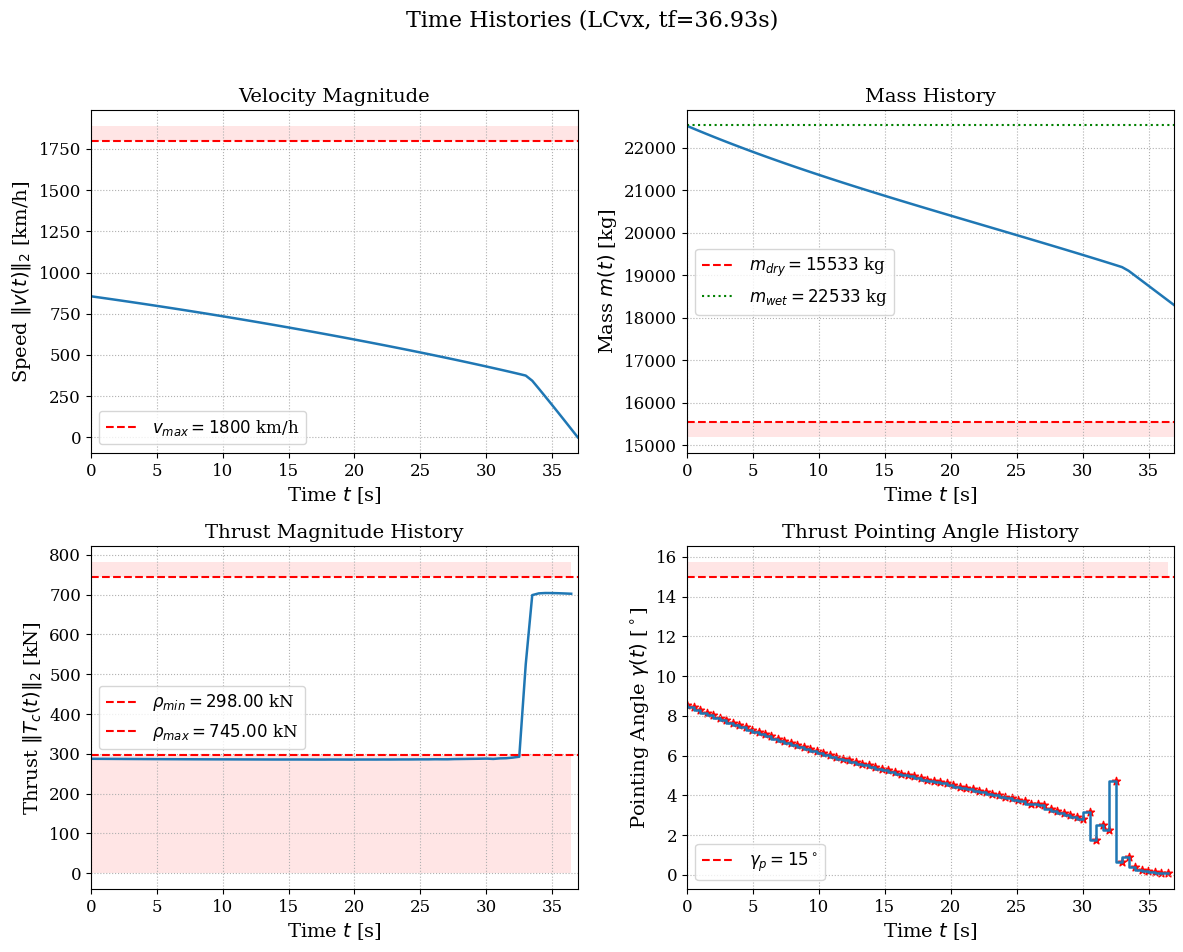

In [97]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# --- 시각화 함수 ---


def set_fonts(small_sz=12, med_sz=14, big_sz=16):
    plt.rc("text", usetex=False)  # Disable LaTeX
    plt.rc("font", size=small_sz, family="serif")
    plt.rc("axes", titlesize=med_sz)
    plt.rc("axes", labelsize=med_sz)
    plt.rc("xtick", labelsize=small_sz)
    plt.rc("ytick", labelsize=small_sz)
    plt.rc("legend", fontsize=small_sz)
    plt.rc("figure", titlesize=big_sz)

def plot_3d_trajectory(solution: Solution, rocket: RocketParams, title_suffix=""):
    """3D 궤적, 제어 벡터, 지면 투영 시각화 (축 스케일 동일)"""
    if solution.status not in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
        print("Cannot plot: Optimization did not succeed.")
        return

    r_opt_km = solution.r * 1e-3 # km 단위로 변환
    T_opt = solution.T # 추력 벡터 [N]
    t_opt = solution.t # 시간 벡터 [s]
    N = len(t_opt)
    N_ctrl = T_opt.shape[1] # 제어 벡터 개수 (N-1)

    set_fonts()
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # --- 플롯 요소 스타일 ---
    style_traj = {'color': 'C0', 'linewidth': 2.5, 'label': 'Trajectory'}
    style_start = {'color': 'green', 'marker': 'o', 'markersize': 8, 'label': 'Start'}
    style_end = {'color': 'red', 'marker': 'o', 'markersize': 8, 'label': 'End'}
    style_controls = {'color': 'black', 'length': 0.15, 'normalize': True,
                      'arrow_length_ratio': 0.4, 'label': 'Thrust Direction'}
    style_proj_traj = {'linestyle': ':', 'color': 'grey', 'label': 'Ground Projection'}
    style_proj_ctrl = {'color': 'darkgrey', 'alpha': 0.6, 'length': 0.15,
                       'normalize': True, 'arrow_length_ratio': 0.4}

    # 1. 3D 궤적
    ax.plot(r_opt_km[0, :], r_opt_km[1, :], r_opt_km[2, :], **style_traj)
    ax.plot([r_opt_km[0, 0]], [r_opt_km[1, 0]], [r_opt_km[2, 0]], **style_start)
    ax.plot([r_opt_km[0, -1]], [r_opt_km[1, -1]], [r_opt_km[2, -1]], **style_end)

    # 2. 제어 벡터 (추력 방향) - 일정 간격으로 샘플링
    step = max(1, N_ctrl // 20) # 약 20개 표시
    plot_indices = np.arange(0, N_ctrl, step)
    ax.quiver(r_opt_km[0, plot_indices], r_opt_km[1, plot_indices], r_opt_km[2, plot_indices],
              T_opt[0, plot_indices], T_opt[1, plot_indices], T_opt[2, plot_indices],
              **style_controls)

    # 3. XY 평면 투영 (Ground Projection)
    ax.plot(r_opt_km[0, :], r_opt_km[1, :], 0, **style_proj_traj)
    ax.quiver(r_opt_km[0, plot_indices], r_opt_km[1, plot_indices], 0,
              T_opt[0, plot_indices], T_opt[1, plot_indices], 0, # Z 방향은 0
              **style_proj_ctrl)

    # 4. 축 레이블 및 타이틀
    ax.set_xlabel("Downrange $r_x$ [km]")
    ax.set_ylabel("Crossrange $r_y$ [km]")
    ax.set_zlabel("Altitude $r_z$ [km]")
    ax.set_title(f"Rocket Landing Trajectory {title_suffix}")

    # 5. 시점 조정
    ax.view_init(elev=25., azim=-120)

    # 6. 축 스케일 동일하게 설정
    x_range = np.ptp(r_opt_km[0,:])
    y_range = np.ptp(r_opt_km[1,:])
    z_range = np.ptp(r_opt_km[2,:])
    max_range = max(x_range, y_range, z_range, 0.1) # 최소 범위 보장
    mid_x = (np.max(r_opt_km[0,:]) + np.min(r_opt_km[0,:])) * 0.5
    mid_y = (np.max(r_opt_km[1,:]) + np.min(r_opt_km[1,:])) * 0.5
    mid_z = (np.max(r_opt_km[2,:]) + np.min(r_opt_km[2,:])) * 0.5
    ax.set_xlim(mid_x - max_range * 0.6, mid_x + max_range * 0.6) # 여유 공간 추가
    ax.set_ylim(mid_y - max_range * 0.6, mid_y + max_range * 0.6)
    # 고도는 0 이하로 잘 안내려가도록 조정
    ax.set_zlim(max(mid_z - max_range * 0.6, -0.1), mid_z + max_range * 0.6)

    # 7. 범례 및 그리드
    ax.legend(loc='upper left', bbox_to_anchor=(0.7, 0.95))
    ax.grid(True)

    plt.tight_layout()
    plt.show()

def plot_time_histories(solution: Solution, rocket: RocketParams, title_suffix=""):
    """속도, 질량, 추력, 포인팅 각도의 시간 변화 플롯"""
    if solution.status not in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
        print("Cannot plot: Optimization did not succeed.")
        return

    t_opt = solution.t
    t_ctrl = t_opt[:-1] # 제어 입력은 N-1개
    N = len(t_opt)

    set_fonts()
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f"Time Histories {title_suffix}", fontsize=16)

    # --- 스타일 ---
    style_line = {'color': 'C0', 'linewidth': 1.8}
    style_points = {'color': 'C1', 'linestyle': 'none', 'marker': '.', 'markersize': 5}
    style_constraint = {'color': 'red', 'linestyle': '--', 'linewidth': 1.5}
    style_constraint_fill = {'edgecolor': 'none', 'facecolor': 'red', 'alpha': 0.1}

    # 1. 속도 크기 (Speed)
    ax = axs[0, 0]
    speed_kmh = np.linalg.norm(solution.v, axis=0) * 3.6 # km/h로 변환
    v_max_kmh = rocket.v_max * 3.6
    ax.plot(t_opt, speed_kmh, **style_line)
    # ax.plot(t_opt, speed_kmh, **style_points) # 점은 생략 가능
    ax.axhline(y=v_max_kmh, **style_constraint, label=f'$v_{{max}} = {v_max_kmh:.0f}$ km/h')
    ax.fill_between(t_opt, v_max_kmh, ax.get_ylim()[1], **style_constraint_fill)
    ax.set_ylabel("Speed $\|v(t)\|_2$ [km/h]")
    ax.set_title("Velocity Magnitude")
    ax.legend()

    # 2. 질량 (Mass)
    ax = axs[0, 1]
    ax.plot(t_opt, solution.m, **style_line)
    # ax.plot(t_opt, solution.m, **style_points)
    ax.axhline(y=rocket.m_dry, **style_constraint, label=f'$m_{{dry}} = {rocket.m_dry:.0f}$ kg')
    ax.fill_between(t_opt, ax.get_ylim()[0], rocket.m_dry, **style_constraint_fill)
    ax.axhline(y=rocket.m_wet, color='green', linestyle=':', linewidth=1.5, label=f'$m_{{wet}} = {rocket.m_wet:.0f}$ kg')
    ax.set_ylabel("Mass $m(t)$ [kg]")
    ax.set_title("Mass History")
    ax.legend()

    # 3. 추력 크기 (Thrust Magnitude)
    ax = axs[1, 0]
    thrust_kN = solution.T_nrm * 1e-3 # kN으로 변환
    rho_min_kN = rocket.rho_min * 1e-3
    rho_max_kN = rocket.rho_max * 1e-3
    ax.plot(t_ctrl, thrust_kN, **style_line)
    # ax.plot(t_ctrl, thrust_kN, **style_points)
    ax.axhline(y=rho_min_kN, **style_constraint, label=f'$\\rho_{{min}} = {rho_min_kN:.2f}$ kN')
    ax.fill_between(t_ctrl, 0, rho_min_kN, **style_constraint_fill)
    ax.axhline(y=rho_max_kN, **style_constraint, label=f'$\\rho_{{max}} = {rho_max_kN:.2f}$ kN')
    ax.fill_between(t_ctrl, rho_max_kN, ax.get_ylim()[1], **style_constraint_fill)
    ax.set_ylabel("Thrust $\|T_c(t)\|_2$ [kN]")
    ax.set_title("Thrust Magnitude History")
    ax.legend()

    # 4. 포인팅 각도 (Pointing Angle)
    ax = axs[1, 1]
    gamma_p_deg = np.rad2deg(rocket.gamma_p_rad)
    ax.step(t_ctrl, solution.gamma_point, **style_line)
    ax.scatter(t_ctrl, solution.gamma_point, color = "red",marker = "*")
    # ax.plot(t_ctrl, solution.gamma_point, **style_points)
    ax.axhline(y=gamma_p_deg, **style_constraint, label=f'$\\gamma_p = {gamma_p_deg:.0f}^\\circ$')
    ax.fill_between(t_ctrl, gamma_p_deg, ax.get_ylim()[1], **style_constraint_fill)
    ax.set_ylabel(r"Pointing Angle $\gamma(t)$ [$^\circ$]")
    ax.set_title("Thrust Pointing Angle History")
    ax.legend()

    # 공통 축 설정
    for ax_row in axs:
        for ax in ax_row:
            ax.set_xlabel("Time $t$ [s]")
            ax.set_xlim([0, t_opt[-1]])
            ax.grid(True, linestyle=':')

    plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # 제목 겹침 방지
    plt.show()


# --- 메인 코드에서 시각화 함수 호출 ---
if pdg_solution.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
    print("\n--- Plotting Results ---")
    plot_3d_trajectory(pdg_solution, rocket_params, title_suffix=f"(LCvx, tf={tf_opt:.2f}s)")
    plot_time_histories(pdg_solution, rocket_params, title_suffix=f"(LCvx, tf={tf_opt:.2f}s)")


--- Plotting 2D Projections ---


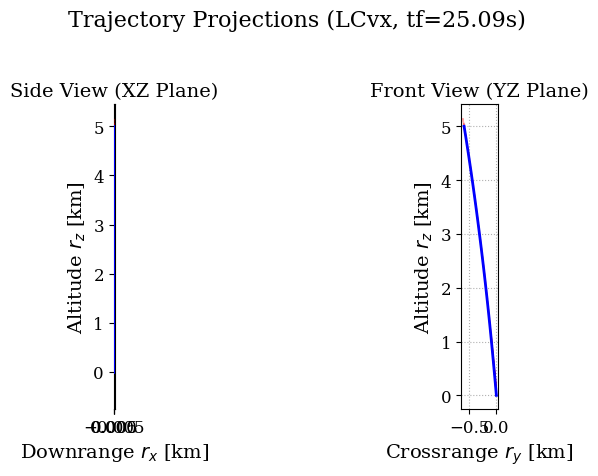

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp # Solution, RocketParams 클래스 정의에 필요할 수 있음

# --- 이전 코드 부분 (RocketParams, Solution 클래스 정의 등) ---
# ... (여기에 필요한 클래스 정의가 있다고 가정) ...

# --- 2D 궤적 시각화 함수 ---

def set_fonts(small_sz=12, med_sz=14, big_sz=16):
    plt.rc("text", usetex=False)  # Disable LaTeX
    plt.rc("font", size=small_sz, family="serif")
    plt.rc("axes", titlesize=med_sz)
    plt.rc("axes", labelsize=med_sz)
    plt.rc("xtick", labelsize=small_sz)
    plt.rc("ytick", labelsize=small_sz)
    plt.rc("legend", fontsize=small_sz)
    plt.rc("figure", titlesize=big_sz)

def plot_2d_projection(ax, r_proj1, r_proj2, T_proj1, T_proj2,
                       thrust_norm, rho_max_kN,
                       rocket: RocketParams,
                       xlabel="", ylabel="", title="",
                       show_glide_slope=False):
    """주어진 축에 2D 궤적 및 추력 벡터를 그리는 헬퍼 함수"""

    # --- 스타일 ---
    style_traj = {'color': 'blue', 'linewidth': 2.0, 'zorder': 5}
    style_thrust = {'color': 'red', 'alpha': 0.3, 'width': 0.002,
                    'head_width': 0.015, 'head_length': 0.03, 'zorder': 3}
    style_glide_slope = {'color': 'blue', 'linestyle': '--', 'linewidth': 1.5, 'zorder': 4}
    style_ground = {'facecolor': "brown", 'edgecolor': "none", 'alpha': 0.15, 'zorder': 1}
    style_activation_pt = {'color': 'black', 'marker': '.', 'markersize': 10, 'zorder': 6}

    # 1. 궤적 그리기
    ax.plot(r_proj1, r_proj2, **style_traj)

    # 2. 추력 벡터 그리기 (크기 비례, 샘플링)
    N_ctrl = len(thrust_norm)
    step = max(1, N_ctrl // 50) # 좀 더 많은 벡터 표시 (50개 정도)
    plot_indices = np.arange(0, N_ctrl, step)
    max_thrust_val = rho_max_kN # 시각적 스케일링 기준

    for k in plot_indices:
        # 추력 크기에 비례하여 길이 조절 (너무 길지 않게 최대값 제한)
        vec_len_scale = min(thrust_norm[k] / max_thrust_val * 0.3, 0.3) # 최대 시각적 길이 0.3km
        # 방향 벡터 (정규화)
        dir1 = T_proj1[k] / (thrust_norm[k] + EPS)
        dir2 = T_proj2[k] / (thrust_norm[k] + EPS)
        # Quiver 대신 arrow 사용 (더 세밀한 제어 가능)
        ax.arrow(r_proj1[k], r_proj2[k], dir1 * vec_len_scale, dir2 * vec_len_scale,
                 **style_thrust)

    # 3. 글라이드 슬로프 및 지면 그리기 (옵션)
    if show_glide_slope:
        ylim = ax.get_ylim()
        xlim = ax.get_xlim()
        ground_level = 0.0
        ground_fill_bottom = ylim[0] - 0.5 # Y축 하한보다 약간 아래

        # 글라이드 슬로프 라인 계산 (원점을 지남)
        # H_gs[0] = [cgs, 0, -sgs] -> cgs*rx - sgs*rz <= 0 => rz >= rx * cgs/sgs = rx / tan(gamma_gs)
        # H_gs[1] = [-cgs, 0, -sgs] -> -cgs*rx - sgs*rz <= 0 => rz >= -rx * cgs/sgs = -rx / tan(gamma_gs)
        # => rz >= |rx| / tan(gamma_gs)
        gs_angle = rocket.gamma_gs_rad
        if np.tan(gs_angle) > EPS: # 0으로 나누기 방지
            gs_limit = abs(xlim[1] if abs(xlim[1]) > abs(xlim[0]) else xlim[0]) # X축 최대 범위 사용
            gs_x = np.array([-gs_limit, 0, gs_limit]) * 1.1 # 약간 넓게
            gs_y = np.abs(gs_x) / np.tan(gs_angle)
            ax.plot(gs_x, gs_y, **style_glide_slope)

        # 지면 채우기
        ax.fill_between(xlim, ground_fill_bottom, ground_level, **style_ground)
        ax.set_ylim(bottom=ground_fill_bottom) # 채운 부분 보이도록 Y축 하한 조정
        ax.set_xlim(xlim) # fill_between으로 변경될 수 있는 X축 한계 복원

        # 글라이드슬로프 활성화 지점 표시 (근사적)
        # H_gs * r <= h_gs (h_gs=0) 에서 등호가 성립하는 지점 찾기
        for k in range(len(r_proj1)):
            r_vec = np.array([pdg_solution.r[0,k], pdg_solution.r[1,k], pdg_solution.r[2,k]])
            violations = rocket.H_gs @ r_vec - rocket.h_gs
            # 모든 제약이 거의 0에 가깝거나 음수이고, 고도가 0 이상인 지점
            if np.all(violations < 1e-2) and r_proj2[k] > 1e-3: # 약간의 허용 오차
                 is_active = np.any(abs(violations)<1e-2) # 하나라도 등호에 가까우면
                 if is_active:
                     ax.plot(r_proj1[k], r_proj2[k], **style_activation_pt)


    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, linestyle=':')
    ax.set_aspect('equal', adjustable='box') # 가로세로 비율 동일하게

def plot_2d_projections(solution: Solution, rocket: RocketParams, title_suffix=""):
    """XZ 및 YZ 평면 궤적 플롯 생성"""
    if solution.status not in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
        print("Cannot plot: Optimization did not succeed.")
        return

    r_opt_km = solution.r * 1e-3
    T_opt_kN = solution.T * 1e-3
    thrust_norm_kN = solution.T_nrm * 1e-3
    rho_max_kN = rocket.rho_max * 1e-3

    set_fonts()
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f"Trajectory Projections {title_suffix}", fontsize=16)

    # XZ 평면 플롯 (Downrange vs Altitude)
    plot_2d_projection(axs[0], r_opt_km[0, :], r_opt_km[2, :], # r_x, r_z
                       T_opt_kN[0, :], T_opt_kN[2, :],         # T_x, T_z
                       thrust_norm_kN, rho_max_kN, rocket,
                       xlabel="Downrange $r_x$ [km]", ylabel="Altitude $r_z$ [km]",
                       title="Side View (XZ Plane)", show_glide_slope=True)

    # YZ 평면 플롯 (Crossrange vs Altitude)
    plot_2d_projection(axs[1], r_opt_km[1, :], r_opt_km[2, :], # r_y, r_z
                       T_opt_kN[1, :], T_opt_kN[2, :],         # T_y, T_z
                       thrust_norm_kN, rho_max_kN, rocket,
                       xlabel="Crossrange $r_y$ [km]", ylabel="Altitude $r_z$ [km]",
                       title="Front View (YZ Plane)", show_glide_slope=False) # YZ는 글라이드슬로프 직접 표시 어려움

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# --- 메인 코드에서 시각화 함수 호출 ---
if pdg_solution.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
    print("\n--- Plotting 2D Projections ---")
    plot_2d_projections(pdg_solution, rocket_params, title_suffix=f"(LCvx, tf={tf_opt:.2f}s)")

    # 기존 3D 및 시간 변화 플롯 호출도 유지 가능
    # print("\n--- Plotting Results ---")
    # plot_3d_trajectory(pdg_solution, rocket_params, title_suffix=f"(LCvx, tf={tf_opt:.2f}s)")
    # plot_time_histories(pdg_solution, rocket_params, title_suffix=f"(LCvx, tf={tf_opt:.2f}s)")